# Проект: Статистический анализ данных для сервиса аренды самокатов GoFast

Цель работы: проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

План работы: 
1) провести предобратку данных; \
2) исследовать частотные зависимости; \
3) объединить данные из трех таблиц; \
4) подсчитать выручку; \
5) проверка гипотез; \
6) общий вывод по проделанной работе.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom
import math

#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [3]:
users.info()
users.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [4]:
rides = pd.read_csv('/datasets/rides_go.csv')
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [39]:
#округление расстояния и продолжительности поездок
import numpy as np

rides['duration'] = np.ceil(rides['duration'])
rides['distance'] = rides['distance'].round(2)
rides.head()

,user_id,distance,duration,date,date_month
0,1,4409.92,26.0,2021-01-01,1
1,1,2617.59,16.0,2021-01-18,1
2,1,754.16,7.0,2021-04-20,4
3,1,2694.78,19.0,2021-08-11,8
4,1,4028.69,27.0,2021-08-28,8


In [6]:
rides.info()
rides.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


user_id     0
distance    0
duration    0
date        0
dtype: int64

In [44]:
rides.describe()

,user_id,distance,duration,date_month
count,18068.000000,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659992,18.303520,6.486772
std,434.734317,1116.831222,6.094928,3.437410
min,1.000000,0.860000,1.000000,1.000000
25%,487.000000,2543.227500,14.000000,4.000000
50%,889.000000,3133.610000,18.000000,6.000000
75%,1213.250000,3776.220000,22.000000,9.000000
max,1534.000000,7211.010000,41.000000,12.000000


In [7]:
subs = pd.read_csv('/datasets/subscriptions_go.csv')
subs

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subs.info()
subs.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

На входе получили 3 таблицы с данными: 1) users - информация о пользователях(id, имя пользователя, возраст, город, тип подписки)
2) rides - информация о поездках (id, расстояние, продолжительность сессии, дата)
3) subs - информация о подписках (тип подписки, стоимость одной минуты поездки, стоимость начала поездки, стоимость ежемесячного платежа)
Пропущенных значений в трех таблицах нет.
Для дальнейшейшего анализа необходимо проверить данные на дубликаты и привести столбец rides['date'] к типу даты в библиотеке пандас.

#### Шаг 2. Предобработка данных

##### Приведите столбец date к типу даты pandas.

In [9]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%dT%H:%M:%S')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


##### Создайте новый столбец с номером месяца на основе столбца date.

In [10]:
rides['date_month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,date_month
0,1,4409.92,26.0,2021-01-01,1
1,1,2617.59,16.0,2021-01-18,1
2,1,754.16,7.0,2021-04-20,4
3,1,2694.78,19.0,2021-08-11,8
4,1,4028.69,27.0,2021-08-28,8


##### Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют.

Пропуски были проверены в первом этапе, оказалось, что их нет ни в одном из датафрэймов. Проверим данные на наличие дубликатов и удалим их.

In [11]:
users.duplicated().sum()

31

In [12]:
users = users.drop_duplicates()
users.duplicated().sum()

0

In [13]:
rides.duplicated().sum()

0

In [14]:
subs.duplicated().sum()

0

Данные считаю полными и готовыми для исследовательского и статистического анализа.

#### Шаг 3. Исследовательский анализ данных

Опишите и визуализируйте общую информацию о пользователях и поездках:

##### частота встречаемости городов;

In [15]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

<AxesSubplot:title={'center':'частота встречаемости городов'}, ylabel='количество пользователей'>

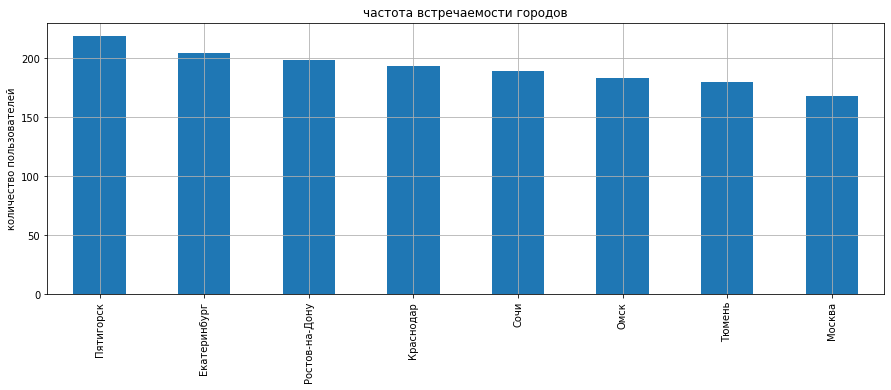

In [16]:
users['city'].value_counts().plot(grid=True, kind = 'bar', figsize=(15, 5), \
                                  title = 'частота встречаемости городов', ylabel = 'количество пользователей')


Чаще всего люди берут самокаты в аренду в г.Пятигорск (219 пользователей), в Москве же сервис не пользуется популярностью. 

##### соотношение пользователей с подпиской и без подписки;

In [17]:
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

<AxesSubplot:title={'center':'частота встречаемости городов'}, ylabel='subscription_type'>

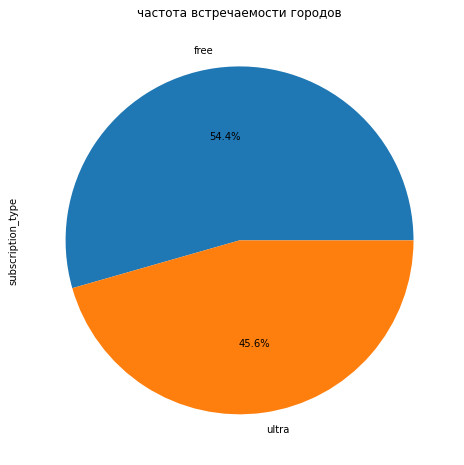

In [18]:
users['subscription_type'].value_counts().plot(grid=True, kind = 'pie', figsize=(8, 8), autopct='%1.1f%%',\
                                               title = 'частота встречаемости городов' )

Чаще люди берут в аренду самокат без подписки.

In [19]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

<AxesSubplot:title={'center':'возраст пользователей'}, ylabel='количество пользователей'>

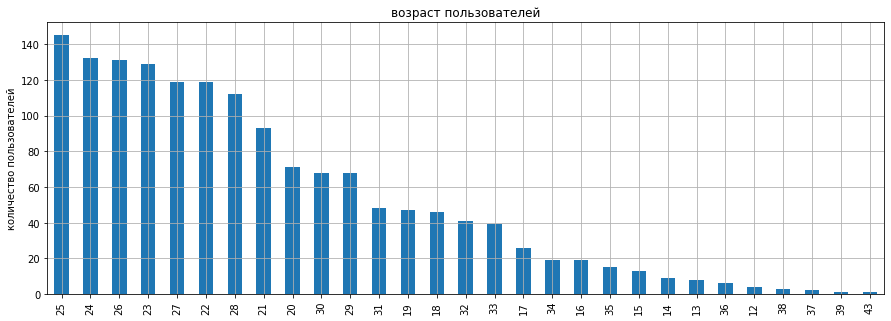

In [20]:
users['age'].value_counts().plot(grid=True, kind = 'bar', figsize=(15, 5), \
                                 title = 'возраст пользователей', ylabel = 'количество пользователей')

Сервисом пользуются люди в возрасте от 12 до 43 лет, средний возраст 24 года. Больше всего пользователей в возрасте 25 лет.

##### расстояние, которое пользователь преодолел за одну поездку;

In [21]:
rides['distance'].describe()

count    18068.000000
mean      3070.659992
std       1116.831222
min          0.860000
25%       2543.227500
50%       3133.610000
75%       3776.220000
max       7211.010000
Name: distance, dtype: float64

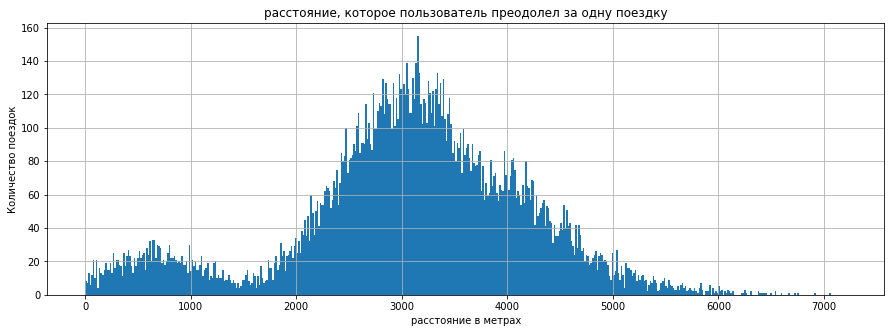

In [22]:
#rides['distance'].hist(bins = 500, figsize=(15, 5), grid=True, range=(1,7211), \
                      #title = 'расстояние, которое пользователь преодолел за одну поездку', ylabel = 'количество пользователей')
plt.figure(figsize=(15, 5))
plt.hist(rides['distance'], bins = 500, range=(1,7211))

plt.title('расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('расстояние в метрах')
plt.ylabel('Количество поездок')
plt.grid(True)
plt.show()

На диаграмме мы видим 2 пика: на значениях порядка 700м и 3100м. Это средние значения наиболее часто встречающихся поездок.

##### продолжительность поездок.

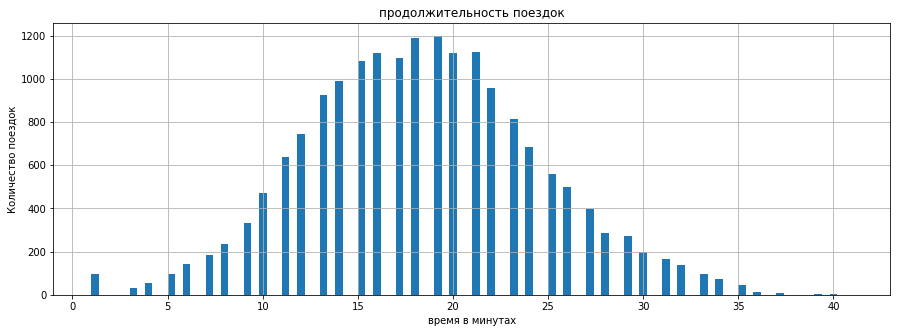

In [40]:
#rides['duration'].hist(bins = 300, figsize=(15, 5), grid=True, range=(1,41))
plt.figure(figsize=(15, 5))
plt.hist(rides['duration'], bins = 100, range=(1,41))
plt.title('продолжительность поездок')
plt.xlabel('время в минутах')
plt.ylabel('Количество поездок')
plt.grid(True)
plt.show()

In [24]:
rides.describe()

,user_id,distance,duration,date_month
count,18068.000000,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659992,18.303520,6.486772
std,434.734317,1116.831222,6.094928,3.437410
min,1.000000,0.860000,1.000000,1.000000
25%,487.000000,2543.227500,14.000000,4.000000
50%,889.000000,3133.610000,18.000000,6.000000
75%,1213.250000,3776.220000,22.000000,9.000000
max,1534.000000,7211.010000,41.000000,12.000000


Средняя продолжительность поездок варьируется от 15 до 20 минут.

#### Шаг 4. Объединение данных

##### Объединение данных о пользователях, поездках и подписках в один датафрейм. 


In [25]:
df = pd.merge(users, subs, on='subscription_type')
df = pd.merge(rides, df, on='user_id')
df.head()

,user_id,distance,duration,date,date_month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,26.0,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,16.0,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,7.0,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,19.0,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,27.0,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   date_month         18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Объединив 3 таблицы users, rides и subs, получили новый датафрэйм df. Количество строк совпадает с исходным rides. Объединение прошло верно.

##### Создание ещё двух датафреймов: c данными о пользователях без подписки и с ней;

In [27]:
df_free = df[df['subscription_type'] == 'free']
df_free.head()

,user_id,distance,duration,date,date_month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.69,15.0,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.93,17.0,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.43,21.0,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.91,10.0,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.38,18.0,2021-02-14,2,Айдар,22,Омск,free,8,50,0


In [28]:
df_ultra = df[df['subscription_type'] == 'ultra']
df_ultra.head()

,user_id,distance,duration,date,date_month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,26.0,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,16.0,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,7.0,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,19.0,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,27.0,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


##### Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий.

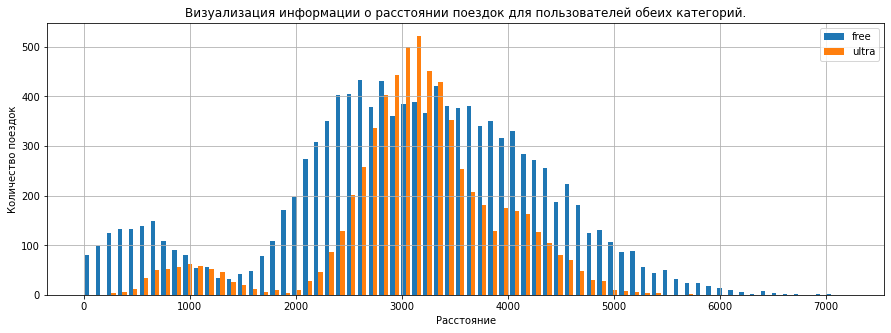

In [29]:
plt.figure(figsize=(15, 5))
plt.hist([df_free['distance'], df_ultra['distance']], bins=70, range=(1,7200), label=['free', 'ultra'])
plt.legend()
plt.title('Визуализация информации о расстоянии поездок для пользователей обеих категорий.')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.grid(True)
plt.show()

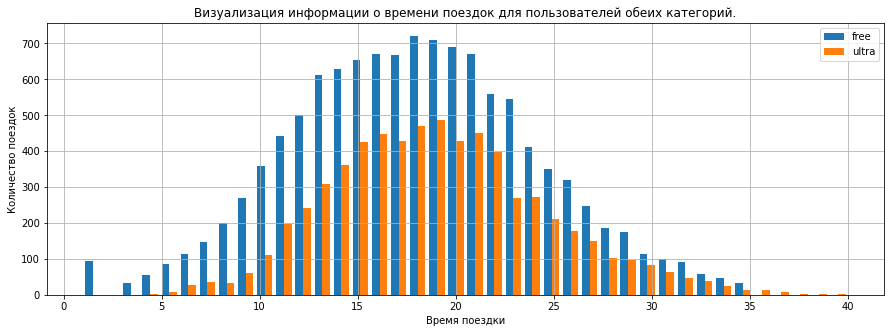

In [30]:
plt.figure(figsize=(15, 5))
plt.hist([df_free['duration'], df_ultra['duration']], bins=40, range=(1,40), label=['free', 'ultra'])
plt.legend()
plt.title('Визуализация информации о времени поездок для пользователей обеих категорий.')
plt.xlabel('Время поездки')
plt.ylabel('Количество поездок')
plt.grid(True)
plt.show()

In [31]:
(
    df_free[['distance', 'duration']]
    .describe()
)

,distance,duration
count,11568.000000,11568.000000
mean,3045.495284,17.890992
std,1246.173810,6.330250
min,0.860000,1.000000
25%,2366.560000,13.000000
50%,3114.650000,18.000000
75%,3905.695000,22.000000
max,7211.010000,35.000000


In [32]:
(
    df_ultra[['distance', 'duration']]
    .describe()
)

,distance,duration
count,6500.000000,6500.000000
mean,3115.445431,19.037692
std,836.895369,5.577439
min,244.210000,4.000000
25%,2785.447500,15.000000
50%,3148.640000,19.000000
75%,3560.577500,22.000000
max,5699.770000,41.000000


В ходе визуализации информации о расстоянии поездок для пользователей обеих категорий выявили следующие зависимости: 
- пик на низких расстояниях больше у пользователей без подписки, то есть они чаще берут самокат для непродолжительных, возможно незапланированных поездках. В то же время пользователи с подпиской чаще совершают более длительные, скорее всего, запланированные поездки. 

Гистограмма для времени поездок пользователей обеих категорий показала, что продолжительность не сильно, но выше у пользователей с подпиской. Разницу в 1-2 минуты можно считать не значительной. 

#### Шаг 5. Подсчёт выручки

##### Создание датафрейма с агрегированными данными о поездках: суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [33]:
df_agg = df.pivot_table(index=['user_id', 'date_month'],
                        values=('distance','duration','minute_price','start_ride_price','subscription_fee'), 
                        aggfunc=({'distance':{'count', 'sum'},'duration':'sum', 'minute_price': 'mean','start_ride_price':'mean','subscription_fee':'mean',}))
                        
df_agg.columns = ['count', 'distance','duration','minute_price','start_ride_price','subscription_fee']
df_agg.head(20)                       

count  distance  duration  minute_price  start_ride_price  \
user_id date_month                                                              
1       1               2   7027.51      42.0             6                 0   
        4               1    754.16       7.0             6                 0   
        8               2   6723.47      46.0             6                 0   
        10              2   5809.91      32.0             6                 0   
        11              3   7003.50      56.0             6                 0   
        12              2   6751.63      28.0             6                 0   
2       3               3  10187.73      63.0             6                 0   
        4               2   6164.39      40.0             6                 0   
        6               1   3255.34      14.0             6                 0   
        7               2   6780.73      48.0             6                 0   
        8               1    923.01       7.0             6                 0   
        10              1   2824.64      19.0             6                 0   
        12              1   3828.25      12.0             6                 0   
3       1               1   3061.78      13.0             6                 0   
        2               2   5421.16      39.0             6                 0   
        4               1   2956.65      21.0             6                 0   
        5               3   9064.03      63.0             6                 0   
        7               3  10919.59      67.0             6                 0   
        9               1   2891.01      23.0             6                 0   
        12              1   2593.38      13.0             6                 0   

                    subscription_fee  
user_id date_month                    
1       1                        199  
        4                        199  
        8                        199  
        10                       199  
        11                       199  
        12                       199  
2       3                        199  
        4                        199  
        6                        199  
        7                        199  
        8                        199  
        10                       199  
        12                       199  
3       1                        199  
        2                        199  
        4                        199  
        5                        199  
        7                        199  
        9                        199  
        12                       199

##### Добавление столбца с помесячной выручкой, которую принёс каждый пользователь.

In [34]:
#import numpy as np

#df_agg['duration'] = np.ceil(df_agg['duration'])

In [35]:
#df_agg['revenue'] = df_agg['count']*(df_agg['duration']*df_agg['minute_price']+df_agg['start_ride_price'])+df_agg['subscription_fee']

df_agg['revenue'] = (df_agg['start_ride_price']*df_agg['count'] + \
                     df_agg['duration']*df_agg['minute_price'] + df_agg['subscription_fee'])

                                                                                                                  
df_agg.head()

count  distance  duration  minute_price  start_ride_price  \
user_id date_month                                                              
1       1               2   7027.51      42.0             6                 0   
        4               1    754.16       7.0             6                 0   
        8               2   6723.47      46.0             6                 0   
        10              2   5809.91      32.0             6                 0   
        11              3   7003.50      56.0             6                 0   

                    subscription_fee  revenue  
user_id date_month                             
1       1                        199    451.0  
        4                        199    241.0  
        8                        199    475.0  
        10                       199    391.0  
        11                       199    535.0

Помесячная выручка для каждого пользователя была рассчитана по формуле: стоимость старта поездки × количество поездок + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки.

#### Шаг 6. Проверка гипотез

##### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.


Выдвинем гипотезы. 

Нулевая: пользователи с подписками обоих типов тратят одинаковое время на поездки. 

Первая: пользователи с подпиской тратят больше времени.

In [36]:
alpha = 0.05

results = st.ttest_ind(
    df_ultra['duration'], 
    df_free['duration'], 
    alternative='greater')

print(results.pvalue)


if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

2.4959453720736625e-34
Отвергаем нулевую гипотезу


In [41]:
print('средняя продолжительность поездок пользователей с подпиской:', df_ultra['duration'].mean()) 
print('средняя продолжительность поездок пользователей без подписки:', df_free['duration'].mean())

средняя продолжительность поездок пользователей с подпиской: 19.037692307692307
средняя продолжительность поездок пользователей без подписки: 17.890992392807746


Нулевая гипотеза отвергнута, как это и было видно из диаграммы. Небольшое увеличение по времени с подпиской есть. Можно сделать вывод, что пользователи с подпиской могут быть «выгоднее» для компании.

##### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает  3130 метров? Проверьте гипотезу и сделайте выводы.


Нулевая гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров.

Первая: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров

In [37]:
interested_value = 3130 

alpha = 0.05 # уровень статистической значимости
            # можно указать .05 или 0.05

results = st.ttest_1samp(
    df_ultra['distance'], 
    interested_value, 
    alternative='less')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.0804637394157586
Не получилось отвергнуть нулевую гипотезу


In [42]:
print('средняя длительность поездок пользователей с подпиской:', df_ultra['distance'].mean()) 

средняя длительность поездок пользователей с подпиской: 3115.445430769231


Не получилось отвергнуть нулевую гипотезу. Действительно, среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает  3130 метров.

##### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.


Нулевая гипотеза: помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки. 
Первая: помесячная выручка от пользователей с подпиской по месяцам больше выручки от пользователей без подписки. 

In [38]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(
    df_agg.loc[df_agg['subscription_fee'] > 0, 'revenue'], 
    df_agg.loc[df_agg['subscription_fee'] == 0, 'revenue'],
    alternative='greater')



print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


In [43]:
print('средняя помесячная выручка от пользователей с подпиской:', df_agg.loc[df_agg['subscription_fee'] > 0, 'revenue'].mean()) 
print('средняя помесячная выручка от пользователей без подписки:',  df_agg.loc[df_agg['subscription_fee'] == 0, 'revenue'].mean())

средняя помесячная выручка от пользователей с подпиской: 362.7921906022502
средняя помесячная выручка от пользователей без подписки: 328.6413651073845


Отвергаем нулевую гипотезу. Можем сделать вывод, что помесячная выручка от пользователей с подпиской по месяцам больше выручки от пользователей без подписки.

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Нам необходимо исследовать наборы данных до и после. Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python, применим метод scipy.stats.ttest_rel(), указак alternative="less".
Ему достаточно передать всего два параметра: наборы данных до и после. Оба набора должны быть одинаковыми по размеру: каждое измерение должно быть проведено до и после изменения.

#### Шаг 7. Распределения (необязательно)

пока не приступала. выполню это задание, как только не будет критических комментарев по обязательным пунктам:)

#### Вывод

В ходе проделанной работы был изучен сервис аренды самокатов GoFast. Для анализа были использованы данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализировали данные и проверили некоторые гипотезы, которые могут помочь бизнесу вырасти.

Работа состояла из 3-х шагов:

Шаг 1. Предобработка данных.
На входе получили 3 таблицы с данными: 1) users - информация о пользователях(id, имя пользователя, возраст, город, тип подписки)
2) rides - информация о поездках (id, расстояние, продолжительность сессии, дата)
3) subs - информация о подписках (тип подписки, стоимость одной минуты поездки, стоимость начала поездки, стоимость ежемесячного платежа)
Пропущенных значений в трех таблицах нет.
Для дальнейшейшего анализа необходимо проверить данные на дубликаты и привести столбец rides['date'] к типу даты в библиотеке пандас.

Пропуски были проверены в первом этапе, оказалось, что их нет ни в одном из датафрэймов. Проверим данные на наличие дубликатов и удалим их.Данные считаю полными и готовыми для исследовательского и статистического анализа.

Шаг 2. Исследовательский анализ, поиск зависимостей.
На этом шаге удалось выявить следующие зависимости: 
- Чаще всего люди берут самокаты в аренду в г.Пятигорск (219 пользователей), в Москве же сервис не пользуется популярностью. 
- 54,4% пользователей берут в аренду самокат без подписки.
- Сервисом пользуются люди в возрасте от 12 до 43 лет, средний возраст 24 года. Больше всего пользователей в возрасте 25 лет.
- На диаграмме мы видим 2 пика: на значениях порядка 700м и 3100м. Это средние значения наиболее часто встречающихся поездок.
- Средняя продолжительность поездок варьируется от 15 до 20 минут.

Далее сгруппировали данные по наличию подписки и расстоянию/времени/стоимости поездок: 
- пик на низких расстояниях больше у пользователей без подписки, то есть они чаще берут самокат для непродолжительных, возможно незапланированных поездках. В то же время пользователи с подпиской чаще совершают более длительные, скорее всего, запланированные поездки.
- Гистограмма для времени поездок пользователей обеих категорий показала, что продолжительность не сильно, но выше у пользователей с подпиской. Разницу в 1-2 минуты можно считать не значительной.
- Помесячная выручка для каждого пользователя была рассчитана по формуле: стоимость старта поездки × количество поездок + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки.

Шаг 3. Проверка гипотез. 
- Нулевая гипотеза 1. Пользователи с подписками обоих типов тратят одинаковое время на поездки.
Нулевая гипотеза отвергнута, как это и было видно из диаграммы. Небольшое увеличение по времени с подпиской есть. Можно сделать вывод, что пользователи с подпиской могут быть «выгоднее» для компании.

- Нулевая гипотеза2: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров.
Не получилось отвергнуть нулевую гипотезу. Действительно, среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

- Нулевая гипотеза3: помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки. 
Нулевая гипотеза отвергнута. Можем сделать вывод, что помесячная выручка от пользователей с подпиской по месяцам больше выручки от пользователей без подписки.

Делаем вывод, что для компании выгоднее, чтобы пользовали оформляли подписку. Стоит обратить на это внимание, для дальнейшего роста выручки.